In [3]:
import numpy as np
import scipy as sp
from scipy import optimize
from scipy import stats
import matplotlib.pyplot as plt
import sys, copy, emcee, corner
%matplotlib inline

In [4]:
sys.path.append('./ligbind/')
import ligbind as lb

In [5]:
def wym_obj(guess,model,data,ligs,rtot):
    datac = np.concatenate(data)
    return (model(guess,ligs,rtot)-datac)

def fit_wym(guess,model,data,ligs,rtot,bnds):
        return sp.optimize.least_squares(wym_obj,guess,args=(model,data,ligs,rtot),bounds=bnds,method='trf',ftol=1e-14,gtol=1e-14,xtol=1e-14)
    
def wym_obj_wt(guess,model,data,ligs,rtot):
    datac = np.concatenate(data)
    return (model(guess,ligs,rtot)-datac)/datac

def fit_wym_wt(guess,model,data,ligs,rtot,bnds):
        return sp.optimize.least_squares(wym_obj_wt,guess,args=(model,data,ligs,rtot),bounds=bnds,method='trf',ftol=1e-14,gtol=1e-14,xtol=1e-14)

In [6]:
def wymfunc_fix(parm,lig,rtot):
    '''
    Model function for dimerizing, single-site receptors as derived in
    (Wyman and Gill, Binding and Linkage, 1990) and used by
    (Macdonald and Pike, ...EGF-binding...negative cooperativity...aggregating system, 2008).
    Takes numpy array of parameters [k11,k21,k22,l20], numpy array of free ligand concentrations,
    and total receptor concentration. Returns the fraction of receptor bound to ligand.

    To generate a data set, iterate over an array of desired receptor concentrations, e.g.:
    [wymfunc(parm,lig,i) for i in array_of_rtots]

    For use in curve fitting an objective function for use with scipy.optimize.least_squares
    is readily constructed as: (wymfun(parm_guess,lig,rtot) - actual_data)
    '''

    #ensure dimension/broadcasting compatibility of inputs
    if ((rtot.ndim > 0) and (rtot.ndim != lig.ndim)):
        rtot = rtot[:,None] #adds dimension so that it can be broadcast
    else:
        rtot = rtot

    #unpack parameters
    k11 = parm[0]
    k21 = parm[1]
    k22 = k21/4.
    l20 = parm[2]

    ### START MODEL FUNCTION ###

    #calculate concentration of free (unoccupied) receptor
    rfree = (((-1 - k11*lig)) + \
    ((np.square((1 + k11*lig)) + \
    8.*l20*rtot*(1 + k21*lig + k21*k22*(np.square(lig)))))**0.5) \
    / (4*l20*(1 + k21*lig + k21*k22*(np.square(lig))))

    #calculate bound fraction
    bfrac = (k11*lig + l20*k21*rfree*lig + \
    2*l20*k21*k22*rfree*(np.square(lig))) \
    / (1 + 2*l20*rfree + k11*lig + \
    2*l20*k21*rfree*lig + 2*l20*k21*k22*rfree*(np.square(lig)))

    ### END MODEL FUNCTION ###

    #flatten output
    if ((rtot.ndim > 0) and (rtot.ndim != lig.ndim)):
        return bfrac.flatten()
    elif (rtot.ndim == 0):
        return bfrac.flatten()
    else:
        return np.concatenate(bfrac)

In [42]:
sim_n05 = lb.WymSim(sets=1000,reps=1,parms=np.array([15.,10.,2.5,5000.]),noise=0.05)
sim_n10 = lb.WymSim(sets=1000,reps=1,parms=np.array([15.,10.,2.5,5000.]),noise=0.1)

In [8]:
guess = np.array([15.,10.,2.5,5000.])
guess_fix = np.array([15.,10.,5000.])

In [9]:
lsbnds = (tuple(1e-5 for i in range(4)),tuple(1e4 for i in range(4)))
lsbnds_fix = (tuple(1e-5 for i in range(3)),tuple(1e4 for i in range(3)))

In [10]:
def ftest(fit1,fit2):
    '''
    fit1 is fit from simpler model
    '''

    SS1 = np.sum(np.square(fit1.fun))
    SS2 = np.sum(np.square(fit2.fun))

    DF1 = fit1.fun.shape[0] - fit1.x.shape[0]
    DF2 = fit2.fun.shape[0] - fit2.x.shape[0]

    F = ((SS1-SS2)/(DF1-DF2))/(SS2/DF2)

    p = sp.stats.f.sf(F,(DF1-DF2),DF2)

    return (SS1,SS2,DF1,DF2,F,p)

In [43]:
res05_full = np.array([fit_wym(guess,lb.models.wymfunc,i,sim_n05.ligs,sim_n05.rtot,lsbnds) for i in sim_n05.meanset])

In [44]:
res05_fix = np.array([fit_wym(guess_fix,wymfunc_fix,i,sim_n05.ligs,sim_n05.rtot,lsbnds_fix) for i in sim_n05.meanset])

In [45]:
ps05 = np.array([ftest(res05_fix[i],res05_full[i])[-1] for i in range(1000)])

In [46]:
np.sum(ps05<0.05)

35

In [15]:
r05fix_parms = np.array([i.x for i in res05_fix])
r05full_parms = np.array([i.x for i in res05_full])

In [16]:
fullratio = r05full_parms[:,1]/r05full_parms[:,2]

(array([  1.,   0.,   0.,   0.,   0.,  12.,  14.,   0.,   0.,   1.]),
 array([-7.06371255, -5.76124989, -4.45878722, -3.15632456, -1.8538619 ,
        -0.55139924,  0.75106342,  2.05352608,  3.35598874,  4.6584514 ,
         5.96091406]),
 <a list of 10 Patch objects>)

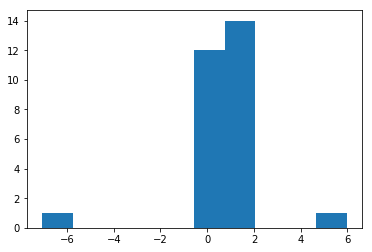

In [17]:
plt.hist(np.log10(fullratio[(ps05<0.05)]))

In [18]:
res10_full = np.array([fit_wym(guess,lb.models.wymfunc,i,sim_n10.ligs,sim_n10.rtot,lsbnds) for i in sim_n10.meanset])

In [19]:
res10_fix = np.array([fit_wym(guess_fix,wymfunc_fix,i,sim_n10.ligs,sim_n10.rtot,lsbnds_fix) for i in sim_n10.meanset])

In [20]:
ps10 = np.array([ftest(res10_fix[i],res10_full[i])[-1] for i in range(1000)])

In [21]:
np.sum(ps10<0.05)

45

In [22]:
res05_full_wt = np.array([fit_wym_wt(guess,lb.models.wymfunc,i,sim_n05.ligs,sim_n05.rtot,lsbnds) for i in sim_n05.meanset])

In [23]:
res05_fix_wt = np.array([fit_wym_wt(guess_fix,wymfunc_fix,i,sim_n05.ligs,sim_n05.rtot,lsbnds_fix) for i in sim_n05.meanset])

In [24]:
ps05_wt = np.array([ftest(res05_fix_wt[i],res05_full_wt[i])[-1] for i in range(1000)])

In [25]:
np.sum(ps05_wt<0.05)

82

In [26]:
res10_full_wt = np.array([fit_wym_wt(guess,lb.models.wymfunc,i,sim_n10.ligs,sim_n10.rtot,lsbnds) for i in sim_n10.meanset])

In [27]:
res10_fix_wt = np.array([fit_wym_wt(guess_fix,wymfunc_fix,i,sim_n10.ligs,sim_n10.rtot,lsbnds_fix) for i in sim_n10.meanset])

In [28]:
ps10_wt = np.array([ftest(res10_fix_wt[i],res10_full_wt[i])[-1] for i in range(1000)])

In [29]:
np.sum(ps10_wt<0.05)

150

In [30]:
r05fix_parms_wt = np.array([i.x for i in res05_fix_wt])
r05full_parms_wt = np.array([i.x for i in res05_full_wt])

In [31]:
fullratio_wt = r05full_parms_wt[:,1]/r05full_parms_wt[:,2]

In [32]:
sig_fullratio = fullratio[ps05<0.05]
sig_fullratio_wt = fullratio_wt[ps05_wt<0.05]

(array([  2.,   5.,   4.,   0.,   0.,  18.,  42.,   8.,   2.,   1.]),
 array([ 0.45889208,  0.49426578,  0.52963948,  0.56501318,  0.60038689,
         0.63576059,  0.67113429,  0.70650799,  0.7418817 ,  0.7772554 ,
         0.8126291 ]),
 <a list of 10 Patch objects>)

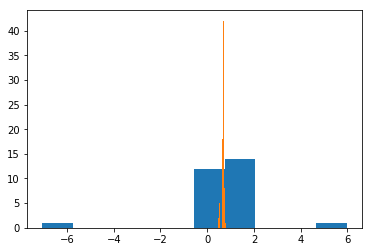

In [33]:
plt.hist(np.log10(sig_fullratio))
plt.hist(np.log10(sig_fullratio_wt))

{'boxes': [<matplotlib.lines.Line2D at 0x114f9aeb8>,
 'caps': [<matplotlib.lines.Line2D at 0x114fa6f28>,
 'fliers': [],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x115081ac8>,
 'whiskers': [<matplotlib.lines.Line2D at 0x114fa1b38>,
  <matplotlib.lines.Line2D at 0x11508c8d0>]}

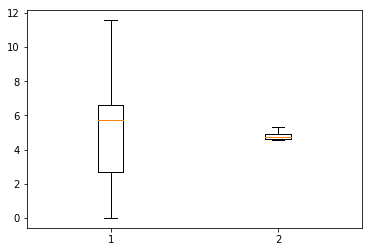

In [34]:
plt.boxplot([(sig_fullratio),(sig_fullratio_wt)],showfliers=False)

In [35]:
np.mean(sig_fullratio)

32645.641183746884

In [36]:
np.mean(sig_fullratio_wt)

4.65755570279285

In [37]:
sig_fullratio_wt.shape

(82,)

In [38]:
sig_fullratio_wt[sig_fullratio_wt>4].shape

(71,)

{'boxes': [<matplotlib.lines.Line2D at 0x1155e59e8>,
 'caps': [<matplotlib.lines.Line2D at 0x11577d9e8>,
 'fliers': [<matplotlib.lines.Line2D at 0x115788f28>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x115788588>,
 'whiskers': [<matplotlib.lines.Line2D at 0x1155e5c88>,
  <matplotlib.lines.Line2D at 0x115793d30>]}

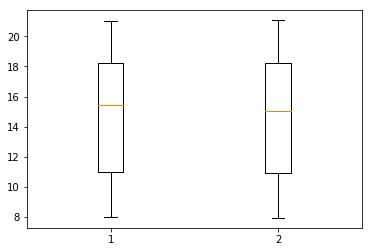

In [40]:
plt.boxplot([(r05fix_parms_wt[:,0]),(r05full_parms_wt[:,0])])

In [41]:
np.mean(r05fix_parms_wt[:,0]),np.mean(r05full_parms_wt[:,0])

(14.666036064025382, 14.642486408620599)

In [169]:
sim_n05 = lb.WymSim(sets=1000,reps=1,parms=np.array([5,5,1.25,1000]),noise=0.05)

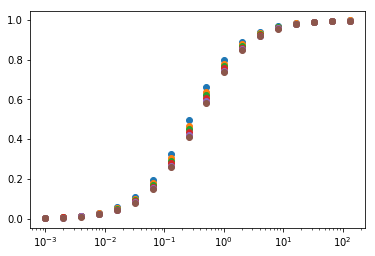

In [170]:
for i in range(len(sim_n05.ligs)):
    plt.semilogx(sim_n05.ligs[i],sim_n05.bfrac[i],'o')